# Siamese Network

Took inspiration from https://github.com/radekosmulski/whale/blob/master/siamese_network_prototype.ipynb

In [43]:
import fastai
from fastai import *
from fastai.vision import *

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')
# to stop fastai from printing out "UserWarning: Tensor is int32: upgrading to int64;"

verbose = True

In [2]:
# global setting
bs = 16
num_workers = 3
# num_workers = 0  # if using kaggle kernel
sz = 224  # image size

data_fp = Path('data')
data_train = 'train'
data_test = 'test'
data_label = 'train.csv'
# crop_fp = data_fp/'cropping.txt'

procedure
* remove all new whales?
* add code that takes into account classes without single images
    * if classes with single image, return a data augmented version or different image
    * if new whale return a random image. 
    
    
 

# Looking at the Data

In [10]:
labels = pd.read_csv(data_fp/data_label)
print(labels.shape)
print(f'Number of classes: {len(labels.Id.unique()):,}')
labels.head()

(25361, 2)
Number of classes: 5,005


,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [80]:
cls_count = labels.Id.value_counts()
cls_one = cls_count[cls_count == 1]
print(f'Number of classes with only one image: {len(cls_one):,}')
print(f'Single image accounts for: {len(cls_one)/len(cls_count):.0%}')
cls_one = cls_one.index.tolist()
cls_one[:5]

Number of classes with only one image: 2,073
Single image accounts for: 41%


['w_45a768c', 'w_81eb375', 'w_b53bfb7', 'w_a687883', 'w_3c80f07']

In [20]:
cls_count.head()  # most common class is new whale

new_whale    9664
w_23a388d      73
w_9b5109b      65
w_9c506f6      62
w_0369a5c      61
Name: Id, dtype: int64

## Train/Validation Split

In [28]:
# pre-determined train/validation split because of the usual situation of having 
# classes with only one data point. In addition, to be able to compare different
# model performance. Code for split is in first_attempt.ipynb section Stratified Split
train_idx = pd.read_csv(data_fp/'train_idx.csv')['index'].tolist()

In [29]:
train_idx[:10]

[21280, 16349, 4289, 13468, 25308, 20273, 12062, 7736, 16585, 10457]

In [30]:
## assess that the number of class are all accounted for in the training indexing
assert len(labels.loc[train_idx, 'Id'].unique()) == len(labels.Id.unique())
print('Number of class {}: {}'.format(len(labels.loc[train_idx, 'Id'].unique()), len(labels['Id'].unique())))
print('Percent of training split: {:.0%}'.format(len(train_idx)/labels.shape[0]))

Number of class 5005: 5005
Percent of training split: 76%


In [32]:
# Fastai expect validation index rather than training set index
val_idx = list(set(labels.index.tolist()) - set(train_idx))
len(val_idx)

6020

# Create Data Bunch

In [40]:
tfms = get_transforms(do_flip=False, max_zoom=1)

In [44]:
# using fastai for splitting, importing, and transforming of the data
src = (ImageItemList.from_df(df=labels, path=data_fp, cols='Image', folder=data_train)
                    .split_by_idx(val_idx)
                    .label_from_df(cols='Id')
                    .add_test_folder(test_folder='test')
                    .transform(tfms, size=sz, resize_method=ResizeMethod.SQUISH))
if verbose: print(src)

LabelLists;

Train: LabelList
y: CategoryList (19341 items)
[Category w_f48451c, Category w_c3d896a, Category w_20df2c5, Category new_whale, Category new_whale]...
Path: data
x: ImageItemList (19341 items)
[Image (3, 700, 1050), Image (3, 325, 758), Image (3, 497, 1050), Image (3, 525, 1050), Image (3, 525, 1050)]...
Path: data;

Valid: LabelList
y: CategoryList (6020 items)
[Category w_64404ac, Category w_a6f9d33, Category new_whale, Category w_cb622a2, Category w_d3b46e7]...
Path: data
x: ImageItemList (6020 items)
[Image (3, 450, 1050), Image (3, 667, 1000), Image (3, 600, 1050), Image (3, 285, 1050), Image (3, 347, 1050)]...
Path: data;

Test: LabelList
y: EmptyLabelList (7960 items)
[EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel , EmptyLabel ]...
Path: .
x: ImageItemList (7960 items)
[Image (3, 522, 1050), Image (3, 390, 683), Image (3, 700, 1050), Image (3, 324, 1050), Image (3, 457, 686)]...
Path: data


In [81]:
'new_whale' in cls_one

False

In [150]:
class PairImgDataset(Dataset):
    def __init__(self, ds, p=0.5):
        """
        Args:
            ds (LabelList): a tuple containing a PIL Image and a Category class
            p (float): probability of returning a same image class sample
        """
        self.ds = ds
        self.cls = ds.y.items  # class's int value
        self.p = p
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
#         same_cls = np.random.choice([0,1], p=[1-self.p, self.p])  # have control over balancing the data
        same_cls = 1
        if same_cls:
            return self.same_class(idx)
        
#         return same_class(idx) if same_cls else diff_class(idx)
    
    
    def same_class(self, idx):
        img1 = self.ds[idx]  # image + class
        
        print('=========Same============')
        print(f'image1: {idx}') # for testing
        
        if img1[1].obj == 'new_whale' or img1[1].obj in cls_one:
            # new_whale and classes with single image are paired with its augmented self
            img2 = self.ds[idx][0]  # fastai return a new augmented image at each access
        else:
            idx2 = np.where(self.cls[idx] == self.cls)[0]  # idx of images with same class including itself
            np.random.shuffle(idx2)  # randomize idx
            img2 = self.ds[idx2[0]][0]
            print(f'image2: {idx2[0]}') # for testing
        return self.combine_img(img1[0], img2, 1)
    
    def diff_class(self, idx):
        img1 = self.ds[idx]
        idxs = self.cls.tolist()
        
        if img1[1].obj != 'new_whale' or img1[1].obj not in cls_one:
            # remove same class images from possible selection
            idxs_same = np.where(self.cls[idx] == self.cls)[0]
            idxs = list(set(idxs) - set(idxs_same))
        
        np.random.shuffle(idxs)
        img2 = self.ds[idxs[0]][0]
        return self.combine_img(img1[0], img2, 0)
        
    def combine_img(self, img1, img2, same_cls):
        return [img1, img2], same_cls

In [151]:
trn = PairImgDataset(src.train)

In [154]:
src.train[1][1].obj in cls_one

False

In [169]:
np.where(src.train.y.items[1] == src.train.y.items)[0]

array([    1,  1814, 14833], dtype=int64)

In [184]:
trn1 = trn[1]

=========Same============
image1: 1
image2: 1814


In [185]:
trn1[0]

[Image (3, 224, 224), Image (3, 224, 224)]

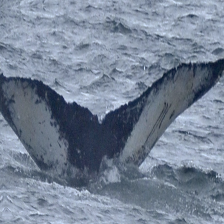

In [186]:
trn1[0][0]

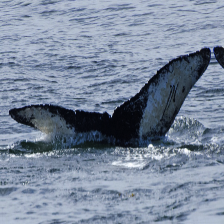

In [187]:
trn1[0][1]

In [127]:
tmp = set(src.train.y.items)

In [131]:
tmp - tmp

set()

In [50]:
tmp.data

3808

In [51]:
len(src.train)

19341

In [134]:
tmp = [1,2,3,4, 5, 6, 7]

In [135]:
np.random.shuffle(tmp)

In [136]:
tmp

[5, 2, 7, 6, 3, 1, 4]

In [78]:
type(tmp.obj)

str

In [117]:
tmp = np.where(src.train.y.items == 10)[0]

In [118]:
tmp

array([ 1906,  2038,  2221,  5015,  5576,  7128,  9682, 10682, 12680, 12828, 13752, 13876, 15037], dtype=int64)

In [119]:
np.random.shuffle(tmp)

In [120]:
tmp[0]

12680

In [97]:
np.random.shuffle??

Docstring:
shuffle(x)

Modify a sequence in-place by shuffling its contents.

This function only shuffles the array along the first axis of a
multi-dimensional array. The order of sub-arrays is changed but
their contents remains the same.

Parameters
----------
x : array_like
    The array or list to be shuffled.

Returns
-------
None

Examples
--------
>>> arr = np.arange(10)
>>> np.random.shuffle(arr)
>>> arr
[1 7 5 2 9 4 3 6 0 8]

Multi-dimensional arrays are only shuffled along the first axis:

>>> arr = np.arange(9).reshape((3, 3))
>>> np.random.shuffle(arr)
>>> arr
array([[3, 4, 5],
       [6, 7, 8],
       [0, 1, 2]])
Type:      builtin_function_or_method
